In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install easyfsl

In [7]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet50
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [8]:
from torch.utils.data import Dataset
from PIL import Image
import os
import pandas as pd
from typing import List

class BlastocystDataset(Dataset):
    def __init__(self, csv_path: str, img_dir: str, transform=None, target: str = "TE"):
        """
        Args:
            csv_path: Path al file CSV con le annotazioni
            img_dir: Directory contenente le immagini
            transform: Trasformazioni da applicare
            target: Colonna target ("ICM_silver", "TE_gold", etc.)
        """
        self.df = pd.read_csv(csv_path, sep=';')
        self.img_dir = img_dir
        self.transform = transform
        self.target = target

        # Pulizia delle etichette
        self._clean_labels()

        # Crea lista di tuple (image_path, label) - equivalente a _flat_character_images
        self.samples = [
            (os.path.join(img_dir, row['Image']), int(row[self.target]))
            for _, row in self.df.iterrows()
        ]

        # Pre-carica le etichette
        self.labels = [label for (_, label) in self.samples]
    def _clean_labels(self):
        """Sostituisce ND con 3 e NaN con valori appropriati"""
        if 'gold' in self.target:  # Solo per il test set
            self.df['ICM_gold'] = self.df['ICM_gold'].replace('ND', 3).fillna(3).astype(int)
            self.df['TE_gold'] = self.df['TE_gold'].replace('ND', 3).fillna(3).astype(int)
            self.df['EXP_gold'] = self.df['EXP_gold'].fillna(0).astype(int)

    def get_labels(self) -> List[int]:
        """Metodo richiesto da TaskSampler"""
        return self.labels

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx]['Image'])
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.iloc[idx][self.target])

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.df)

In [9]:
from torchvision import transforms

# Definizione delle trasformazioni
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Creazione dei dataset
train_dataset = BlastocystDataset(
    csv_path="/content/drive/MyDrive/Blastocyst_Dataset/Gardner_train_silver.csv",
    img_dir="/content/drive/MyDrive/Blastocyst_Dataset/Images",
    transform=train_transform,
    target="TE_silver"  # Modifica per "TE" o "EXP" se necessario
)

test_dataset = BlastocystDataset(
    csv_path="/content/drive/MyDrive/Blastocyst_Dataset/Gardner_test_gold_onlyGardnerScores.csv",
    img_dir="/content/drive/MyDrive/Blastocyst_Dataset/Images",
    transform=test_transform,
    target="TE_gold"
)

Train Class Distribution:
 TE_silver
0    1081
1     525
3     391
2      47
Name: count, dtype: int64

Test Class Distribution:
 TE_gold
0    122
1     82
3     66
2     30
Name: count, dtype: int64


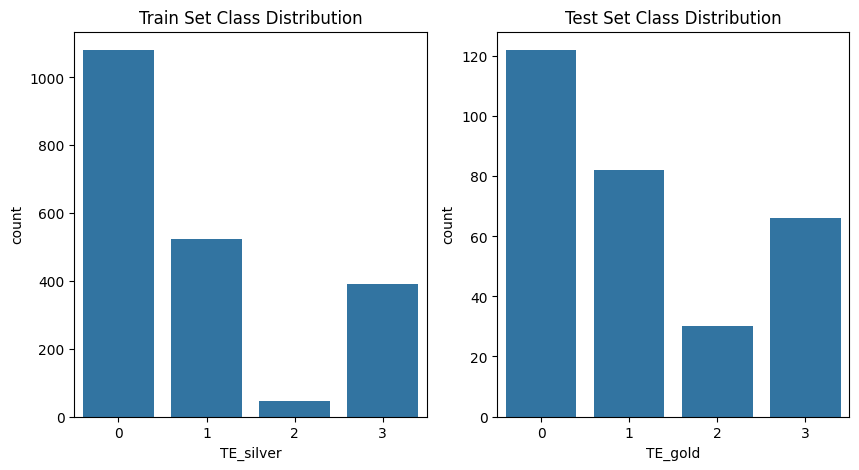

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the correct target column name from the dataset
train_column = train_dataset.target

# Class distribution in train set
train_class_distribution = train_dataset.df[train_column].value_counts()
print("Train Class Distribution:\n", train_class_distribution)

# Class distribution in test set
# Get the correct target column name from the dataset
test_column = test_dataset.target
# Assuming test_dataset uses the same target_class
test_class_distribution = test_dataset.df[test_column].value_counts()
print("\nTest Class Distribution:\n", test_class_distribution)

# Plot class distributions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=train_column, data=train_dataset.df)
plt.title('Train Set Class Distribution')
plt.subplot(1, 2, 2)
sns.countplot(x=test_column, data=test_dataset.df)
plt.title('Test Set Class Distribution')
plt.show()

In [11]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet50(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 91.1MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
N_WAY = 4
N_SHOT = 3          # 3 supporto per classe
N_QUERY = 5        # 5 query per classe
N_TASKS = 100        # Più episodi per statistica

test_sampler = TaskSampler(
    test_dataset,
    n_way=N_WAY,
    n_shot=N_SHOT,
    n_query=N_QUERY,
    n_tasks=N_TASKS,
)

In [13]:


# Creazione del DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_sampler=test_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

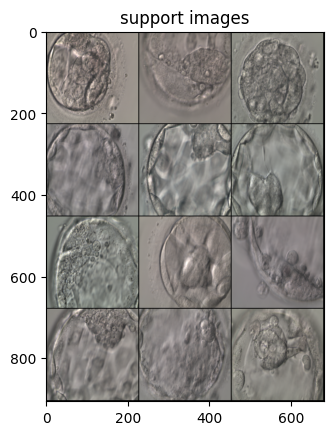

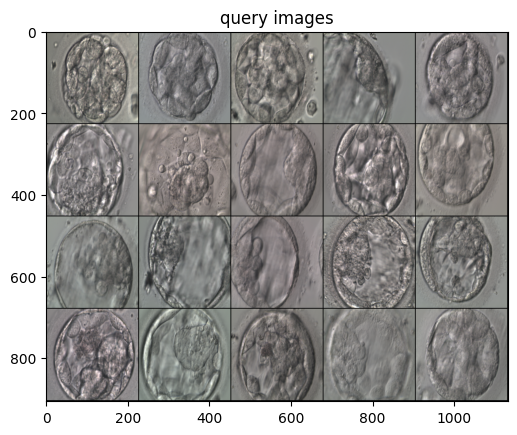

In [14]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [15]:
model.eval()

# Sposta i dati sulla GPU
support_images = example_support_images.cuda()
support_labels = example_support_labels.cuda()
query_images = example_query_images.cuda()

# Calcola i punteggi
with torch.no_grad():
    query_scores = model(support_images, support_labels, query_images).detach()
    _, predicted_labels = torch.max(query_scores.data, 1)

# Converti i tensori in numpy per la stampa
true_labels = example_query_labels.cpu().numpy()
pred_labels = predicted_labels.cpu().numpy()

# Stampa i risultati
print("\nGround Truth (True) / Predicted")
print("-----------------------------")
for true, pred in zip(true_labels, pred_labels):
    print(f"Class {true} / Class {pred}")

# Calcola accuratezza
accuracy = (pred_labels == true_labels).mean()
print(f"\nAccuracy: {accuracy:.2%}")

class_names = {
    0: "TE-A",
    1: "TE-B",
    2: "TE-C",
    3: "TE-ND"
}

print("\nWith class names:")
print("----------------")
for true, pred in zip(true_labels, pred_labels):
    print(f"{class_names.get(true, 'Unknown')} / {class_names.get(pred, 'Unknown')}")


Ground Truth (True) / Predicted
-----------------------------
Class 3 / Class 3
Class 3 / Class 3
Class 3 / Class 3
Class 3 / Class 2
Class 3 / Class 3
Class 0 / Class 2
Class 0 / Class 1
Class 0 / Class 0
Class 0 / Class 3
Class 0 / Class 3
Class 2 / Class 2
Class 2 / Class 2
Class 2 / Class 2
Class 2 / Class 3
Class 2 / Class 3
Class 1 / Class 3
Class 1 / Class 2
Class 1 / Class 3
Class 1 / Class 2
Class 1 / Class 2

Accuracy: 40.00%

With class names:
----------------
TE-ND / TE-ND
TE-ND / TE-ND
TE-ND / TE-ND
TE-ND / TE-C
TE-ND / TE-ND
TE-A / TE-C
TE-A / TE-B
TE-A / TE-A
TE-A / TE-ND
TE-A / TE-ND
TE-C / TE-C
TE-C / TE-C
TE-C / TE-C
TE-C / TE-ND
TE-C / TE-ND
TE-B / TE-ND
TE-B / TE-C
TE-B / TE-ND
TE-B / TE-C
TE-B / TE-C


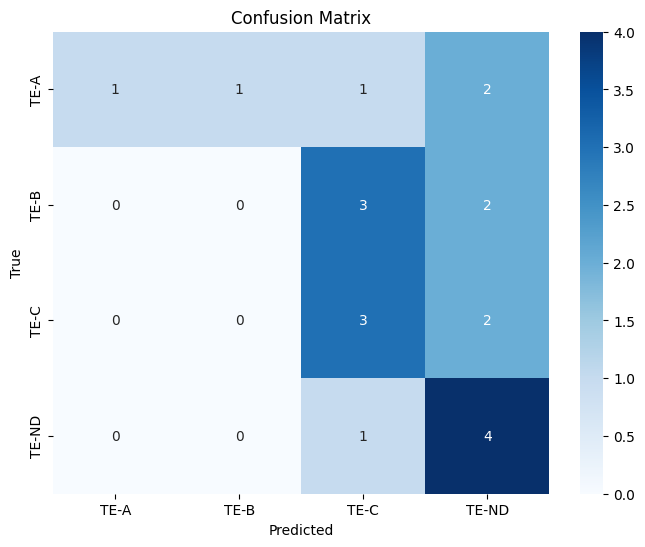

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcola la matrice di confusione
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names.values(),
            yticklabels=class_names.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

100%|██████████| 100/100 [01:29<00:00,  1.11it/s]


Model tested on 100 tasks. Accuracy: 40.30%


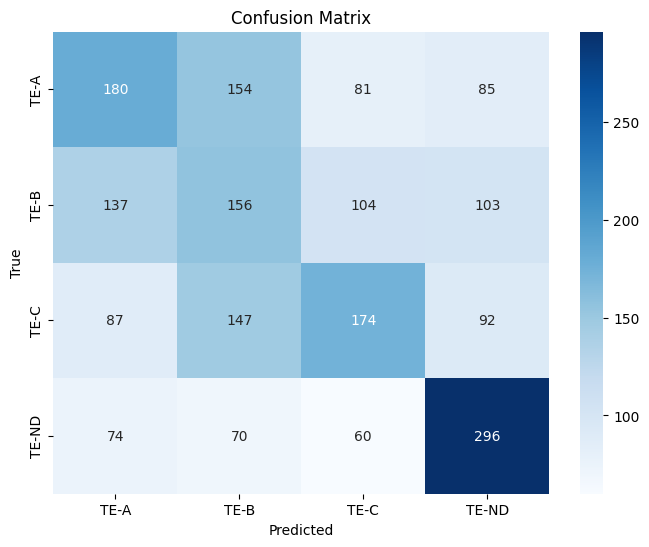

In [17]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    total_predictions = 0
    correct_predictions = 0
    all_true_labels = []  # To store all true labels
    all_pred_labels = []  # To store all predicted labels

    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            # Get predictions for this batch
            classification_scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            _, predicted_labels = torch.max(classification_scores.detach().data, 1)

            # Extend the lists with true and predicted labels
            all_true_labels.extend(query_labels.cpu().numpy())
            all_pred_labels.extend(predicted_labels.cpu().numpy())

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )

    # Calculate and plot the confusion matrix
    cm = confusion_matrix(all_true_labels, all_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names.values(),
                yticklabels=class_names.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


evaluate(test_loader)

In [18]:
N_TRAINING_EPISODES = 5000
N_VALIDATION_TASKS = 100

train_sampler = TaskSampler(
    train_dataset, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

In [20]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

100%|██████████| 5000/5000 [45:33<00:00,  1.83it/s, loss=0.0286]


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


Model tested on 100 tasks. Accuracy: 48.40%


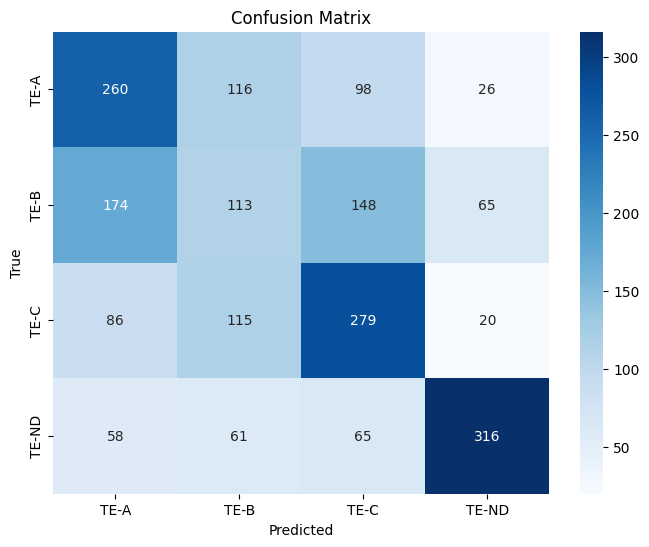

In [21]:
evaluate(test_loader)